# ENES use case 1: data ingest workflow at data center

### Approach: 

* Step1: Generate prov template based on workflow description 
 (copied from existing data ingest workflow handling software)
   * Result: can be done in a few lines of python code

* Step2: experiment with prov template expansion
    *  core problem is the best option to 
        represent the workflow in a provenance graph - many different options .. 
        thus this notebook is used to present different options for representation of
        the provenance template as a basis for discussion:
            
* Step3: Discussion of different template representations of a specific workflow           
   

In [1]:
# import variable setting dictionaries from dkrz data ingest tool chain
# and remove __doc__ strings from dictionary (would clutter PROV graph visualizations)
from provtemplates import workflow_steps

from collections import MutableMapping
from contextlib import suppress

def delete_keys_from_dict(dictionary, keys):
    for key in keys:
        with suppress(KeyError):
            del dictionary[key]
    for value in dictionary.values():
        if isinstance(value, MutableMapping):
            delete_keys_from_dict(value, keys)

workflow_dict = workflow_steps.WORKFLOW_DICT

In [2]:
from provtemplates import provconv
import prov.model as prov
import six
import itertools

from provtemplates import workflow_steps


ns_dict = {
    'prov':'http://www.w3.org/ns/prov#',
    'var':'http://openprovenance.org/var#',
    'vargen':'http://openprovenance.org/vargen#',
    'tmpl':'http://openprovenance.org/tmpl#',
    'foaf':'http://xmlns.com/foaf/0.1/',
    'ex': 'http://example.org/',
    'orcid':'http://orcid.org/',

    #document.set_default_namespace('http://example.org/0/')
    'rdf':'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
    'rdfs':'http://www.w3.org/2000/01/rdf-schema#',
    'xsd':'http://www.w3.org/2001/XMLSchema#',
    'ex1': 'http://example.org/1/',
    'ex2': 'http://example.org/2/'
}

prov_doc01 = provconv.set_namespaces(ns_dict,prov.ProvDocument())
prov_doc02 = provconv.set_namespaces(ns_dict,prov.ProvDocument())
prov_doc03 = provconv.set_namespaces(ns_dict,prov.ProvDocument())
prov_doc1 = prov_doc01.bundle("var:data-ingest-wflow")
prov_doc2 = prov_doc02.bundle("var:data-ingest-wflow")
prov_doc3 = prov_doc03.bundle("var:data-ingest-wflow")
prov_doc01.set_default_namespace('http://enes.org/ns/ingest#')
prov_doc02.set_default_namespace('http://enes.org/ns/ingest#')
prov_doc03.set_default_namespace('http://enes.org/ns/ingest#')


def gen_bundles(workflow_dict,prov_doc):
    global_in_out = prov_doc.entity('var:wf_doc')
    for wflow_step, wflow_stepdict in workflow_dict.items():
        nbundle  = prov_doc.bundle('var:'+wflow_step)
        out_node = nbundle.entity('var:'+wflow_step+'_out')
        agent = nbundle.agent('var:'+wflow_step+'_agent')
        activity = nbundle.activity('var:'+wflow_step+'_activity')
        in_node  = nbundle.entity('var:'+wflow_step+'_in')
    
        nbundle.wasGeneratedBy(out_node,activity)
        nbundle.used(activity,in_node)
        nbundle.wasAssociatedWith(activity,agent)
        nbundle.wasDerivedFrom(in_node,out_node)  
        nbundle.used(activity,global_in_out)
        nbundle.wasGeneratedBy(global_in_out,activity)
        
def in_bundles(workflow_dict,prov_doc):       
    first = True
    out_nodes = []
    nbundle = prov_doc
    for wflow_step, wflow_stepdict in workflow_dict.items():
        #nbundle  = prov_doc.bundle('var:'+wflow_step)
        out_node = nbundle.entity('var:'+wflow_step+'_out')
        agent = nbundle.agent('var:'+wflow_step+'_agent')
        activity = nbundle.activity('var:'+wflow_step+'_activity')
        if first:     
            in_node  = nbundle.entity('var:'+wflow_step+'_in')
            nbundle.used(activity,in_node)
            first = False          
        out_nodes.append((nbundle,out_node,agent,activity))
    return out_nodes    
            
           
def chain_bundles(nodes): 
        '''
        chaining based on "used" activity relationship
        '''
        i = 1
        for (nbundle,out_node,agent,activity) in nodes[1:]:
            (prev_bundle,prev_out,prev_agent,prev_activity) = nodes[i-1]
            nbundle.used(activity,prev_out)
            i += 1
        for (nbundle,out_node,agent,activity) in nodes:    
            nbundle.wasGeneratedBy(out_node,activity)
            nbundle.wasAssociatedWith(activity,agent) 
            
def chain_hist_bundles(nodes,prov_doc):
        '''
         chaining based on "used" activity relationship
         add an explicit end_result composing all the generated
         intermediate results
        '''
        i = 1
        for (nbundle,out_node,agent,activity) in nodes[1:]:
            (prev_bundle,prev_out,prev_agent,prev_activity) = nodes[i-1]
            nbundle.used(activity,prev_out)
            i += 1
        for (nbundle,out_node,agent,activity) in nodes:    
            nbundle.wasGeneratedBy(out_node,activity)
            nbundle.wasAssociatedWith(activity,agent)
        wf_out = prov_doc.entity("ex:wf_result")
        wf_agent = prov_doc.agent("ex:workflow_handler")
        wf_activity = prov_doc.activity("ex:wf_trace_composition")
        prov_doc.wasGeneratedBy(wf_out,wf_activity)
        prov_doc.wasAssociatedWith(wf_activity,wf_agent)
        for (nbundle,out_node,agent,activity) in nodes:
            prov_doc.used(wf_activity,out_node)
        
            


### Template representation variant 1 

* bundles for each workflow step 
 (characterized by output, activity, and agent with relationships)
* every activity uses information from a global provenance log file (used relationship)
  and every activity updates parts of a global provenance log file (was generated by relationship)
  
NB: ! this produces not valid ProvTemplates, as multiple bundles are used 

In [3]:
# generate prov_template options and print provn representation
gen_bundles(workflow_dict,prov_doc01)
print(prov_doc01.get_provn())

document
  default <http://enes.org/ns/ingest#>
  prefix var <http://openprovenance.org/var#>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  prefix orcid <http://orcid.org/>
  prefix rdf <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
  prefix rdfs <http://www.w3.org/2000/01/rdf-schema#>
  prefix ex1 <http://example.org/1/>
  prefix ex2 <http://example.org/2/>
  
  entity(var:wf_doc)
  bundle var:data-ingest-wflow
  endBundle
  bundle var:data_submission
    prefix var <http://openprovenance.org/var#>
    
    entity(var:data_submission_out)
    agent(var:data_submission_agent)
    activity(var:data_submission_activity, -, -)
    entity(var:data_submission_in)
    wasGeneratedBy(var:data_submission_out, var:data_submission_activity, -)
    used(var:data_submission_activity, var:data_submission_in, -)
    wasAssociatedWith(var:data_submission_activity, var:da

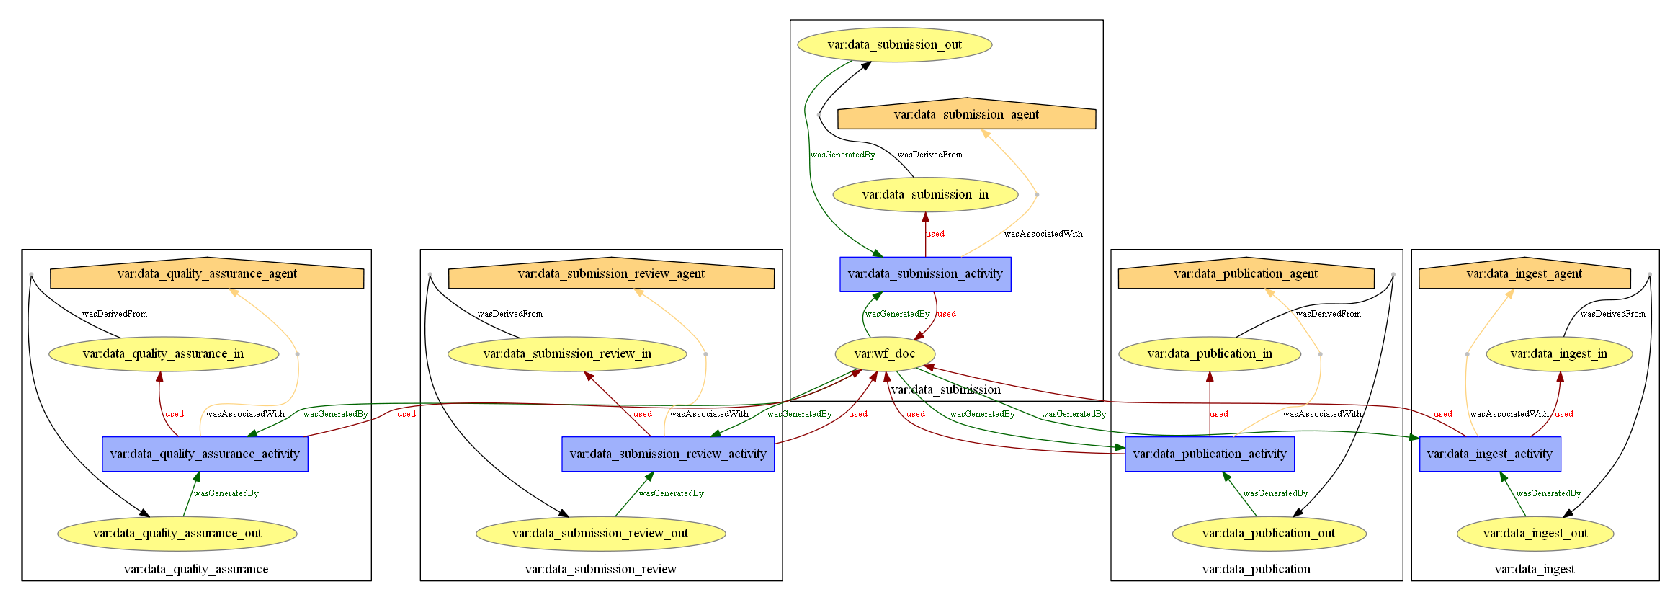

In [4]:
%matplotlib  inline
prov_doc01.plot()
prov_doc01.serialize('data-ingest1.rdf',format='rdf')

### Template representation variant 2:
* workflow steps without bundles 
* workflow steps are chained (output is input to next step) 

In [5]:
nodes = in_bundles(workflow_dict,prov_doc2)
chain_bundles(nodes)
print(prov_doc02.get_provn())

document
  default <http://enes.org/ns/ingest#>
  prefix var <http://openprovenance.org/var#>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  prefix orcid <http://orcid.org/>
  prefix rdf <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
  prefix rdfs <http://www.w3.org/2000/01/rdf-schema#>
  prefix ex1 <http://example.org/1/>
  prefix ex2 <http://example.org/2/>
  
  bundle var:data-ingest-wflow
    prefix var <http://openprovenance.org/var#>
    
    entity(var:data_submission_out)
    agent(var:data_submission_agent)
    activity(var:data_submission_activity, -, -)
    entity(var:data_submission_in)
    used(var:data_submission_activity, var:data_submission_in, -)
    entity(var:data_submission_review_out)
    agent(var:data_submission_review_agent)
    activity(var:data_submission_review_activity, -, -)
    entity(var:data_ingest_out)
    agent(var:data_ing

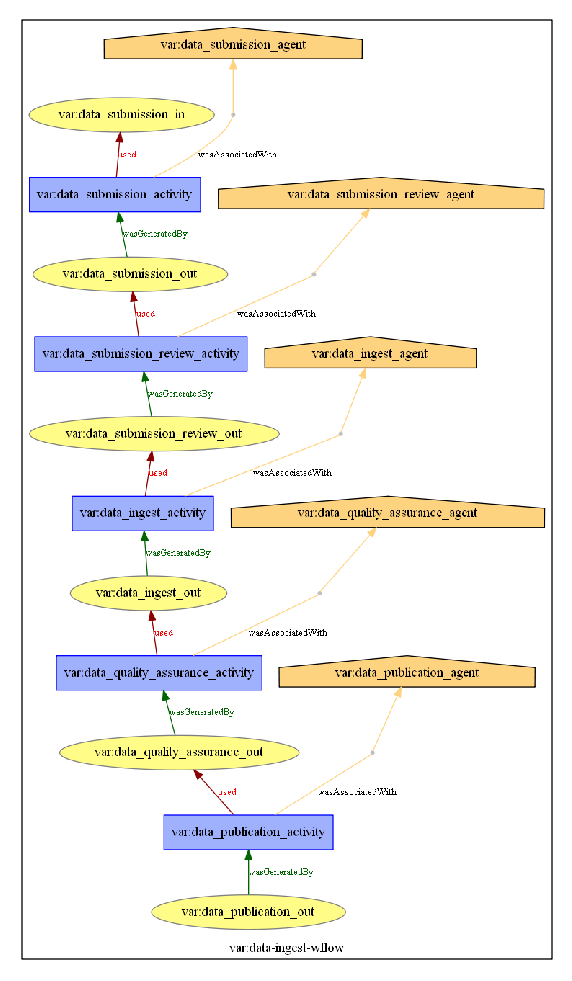

In [7]:
%matplotlib  inline
prov_doc02.plot()
from prov.dot import prov_to_dot
dot = prov_to_dot(prov_doc02)
dot.write_png('ingest-prov-version2.png')

### Template representation variant 3:
* workflow steps without bundles 
* workflow steps are chained (output is input to next step) 
* global workflow representation generation added

In [8]:
gnodes = in_bundles(workflow_dict,prov_doc3)
chain_hist_bundles(gnodes,prov_doc3)
print(prov_doc03.get_provn())
dot = prov_to_dot(prov_doc03)
dot.write_png('ingest-prov-version3.png')

document
  default <http://enes.org/ns/ingest#>
  prefix var <http://openprovenance.org/var#>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  prefix orcid <http://orcid.org/>
  prefix rdf <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
  prefix rdfs <http://www.w3.org/2000/01/rdf-schema#>
  prefix ex1 <http://example.org/1/>
  prefix ex2 <http://example.org/2/>
  
  bundle var:data-ingest-wflow
    prefix var <http://openprovenance.org/var#>
    prefix ex <http://example.org/>
    
    entity(var:data_submission_out)
    agent(var:data_submission_agent)
    activity(var:data_submission_activity, -, -)
    entity(var:data_submission_in)
    used(var:data_submission_activity, var:data_submission_in, -)
    entity(var:data_submission_review_out)
    agent(var:data_submission_review_agent)
    activity(var:data_submission_review_activity, -, -)
    entity(var:dat

In [ ]:
%matplotlib  inline
prov_doc03.plot()
prov_doc03.serialize('data-ingest3.rdf',format='rdf')

In [ ]:
# ------------------ to be removed --------------------------------------

In [ ]:


# generate prov_template options and print provn representation
gen_bundles(workflow_dict,prov_doc1)
print(prov_doc1.get_provn())
nodes = in_bundles(workflow_dict,prov_doc2)
chain_bundles(nodes)
print(prov_doc2.get_provn())
gnodes = in_bundles(workflow_dict,prov_doc3)
chain_hist_bundles(gnodes,prov_doc3)
print(prov_doc3.get_provn())



In [ ]:
%matplotlib  inline
prov_doc1.plot()
prov_doc2.plot()
prov_doc3.plot()